# Border Generation

For TEM (Transmission Electron Microscope) and SEM (Scanning Electron Microscope) Images.

In [148]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

from pathlib import Path

In [149]:
# Constants
IMAGES_DIR_PATH = "/home/pooh555/coding/image_analysis/TEM_NW/20250709-TEM-Yutichai/E8-NW/" # Raw images directory
OUTPUT_DIR_PATH = "./outputs/border_generation/"    # Saved images directory
INPUT_FILE_EXTENSION = "tif"   # Use '*' to include all file extensions
OUTPUT_FILE_EXTENSION = "tif"  # File extension for processed images

### Exploratory Data Analysis

Conduct EDA to examine the properties of the samples.

In [150]:
# Store all images in the direcotry in "images" list
images = []
file_names = []

for file in glob.glob(IMAGES_DIR_PATH + "*." + INPUT_FILE_EXTENSION):
        file_name = Path(file).stem # Extract the original file name (extension excluded)
        images.append(cv2.imread(IMAGES_DIR_PATH + file_name + '.' + INPUT_FILE_EXTENSION, cv2.IMREAD_COLOR_BGR))   # Read and store all images in BGR format
        file_names.append(file_name)

In [151]:
# Check for imparity
print(len(images))
print(len(file_names))

126
126


In [ ]:
# Displaying sample images
def display_images(images):
    print("Displaying images in: " + IMAGES_DIR_PATH)

    num_images_in_figure = 9    # Number of images in the figure
    count = 1   # Image counter

    plt.figure(figsize=(10, 10))    # Figure size

    # Plotting all images
    for image in images:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if (count > num_images_in_figure):
            break

        plt.subplot(3, 3, count)
        plt.imshow(image)  
        plt.axis('off') 
        plt.title(file_name, fontsize=9)

        count += 1

    plt.tight_layout()
    plt.show()

Displaying images in: /home/pooh555/coding/image_analysis/TEM_NW/20250709-TEM-Yutichai/E8-NW/


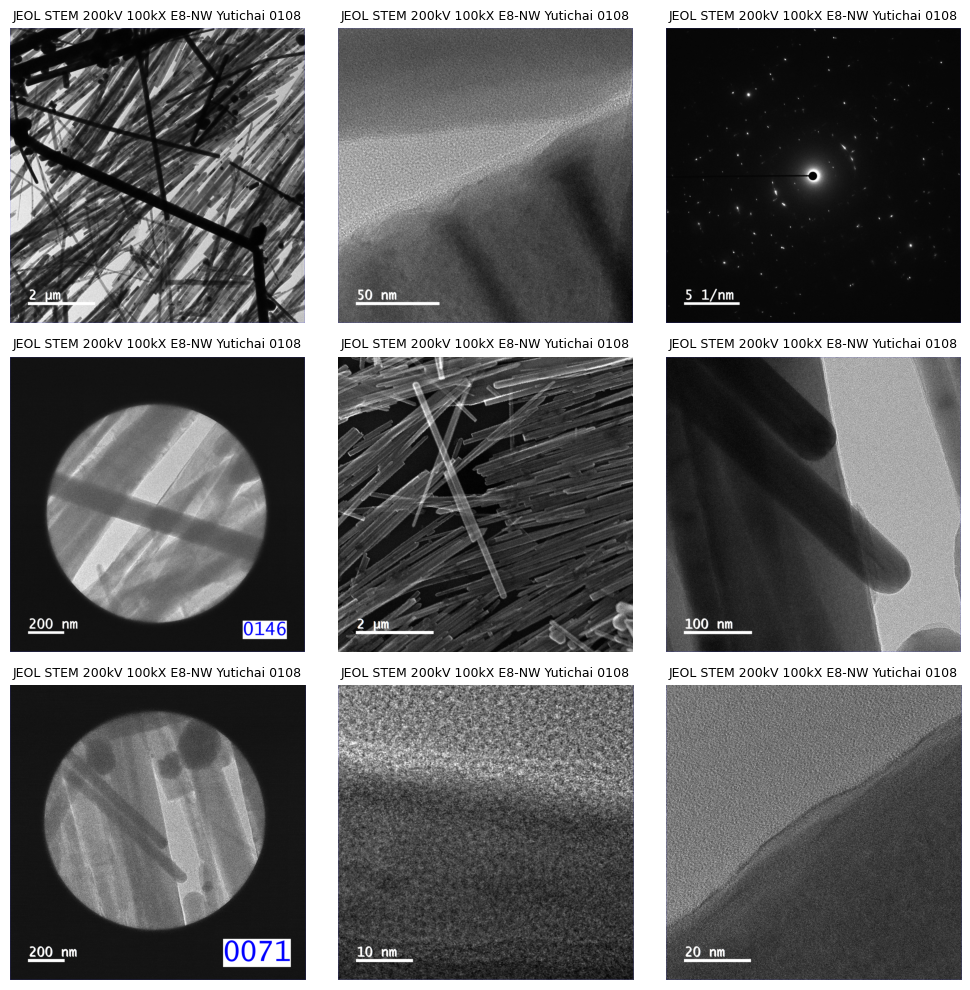

In [153]:
display_images(images)

### Data Preparation

Adjusting constrast, brightness, etc to facilitate border marking process.

In [154]:
# Image Properties Modification Function

# Note: The order of processing layers in this function matters

def modify_image(image, alpha=1.5, beta=2.0, guassian_kernel_size=5, diameter=9, sigmaColor=75, sigmaSpace=75, median_blur_kernel_size=9):
    processed_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    processed_image = cv2.GaussianBlur(processed_image, (guassian_kernel_size, guassian_kernel_size), 0)
    processed_image = cv2.bilateralFilter(processed_image, diameter, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)
    processed_image = cv2.medianBlur(processed_image, median_blur_kernel_size)
    processed_image = cv2.bilateralFilter(processed_image, diameter, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)
    processed_image = cv2.medianBlur(processed_image, median_blur_kernel_size)
    processed_image = cv2.medianBlur(processed_image, median_blur_kernel_size)

    return processed_image

In [155]:
# Modify image properties
modified_images = []

for image in images:
    modified_images.append(modify_image(image, alpha=2.05, beta=2.5, guassian_kernel_size=11, diameter=12, sigmaColor=75, sigmaSpace=25, median_blur_kernel_size=17))


Displaying images in: /home/pooh555/coding/image_analysis/TEM_NW/20250709-TEM-Yutichai/E8-NW/


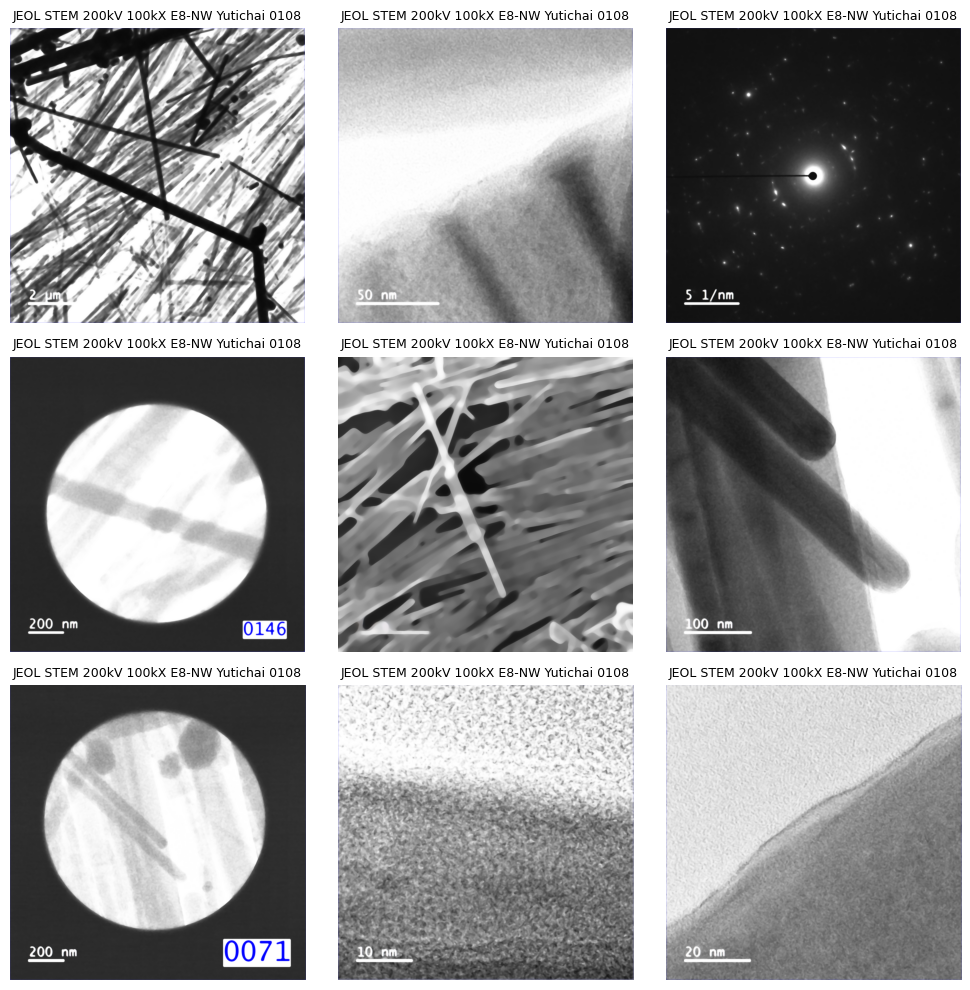

In [156]:
display_images(modified_images)

### Border Synthesis

In [164]:
# Border Generation Function
def generate_border(image, border_size=5, n_erosions=1):
    # Ensure the input image is color (BGR)
    if len(image.shape) == 2:   # Convert greyscale to BGR
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 4:   # Convert RGBA to BGR
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGR)

    greyscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   # Convert the image to grayscale for erosion/dilation operations
    
    # Image erosion
    erosion_kernel = np.ones((3, 3), np.uint8)
    eroded_image_greyscale = cv2.erode(greyscale_image, erosion_kernel, iterations=n_erosions)

    # Image dilation
    kernel_size = 2 * border_size + 1   
    dilation_kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_image_greyscale = cv2.dilate(eroded_image_greyscale, dilation_kernel, iterations=1)

    # Create a mask for the border    
    border_color = (0, 0, 255) # Define the border color (BGR)
    border_mask = ((dilated_image_greyscale == 255) & (eroded_image_greyscale < 255))    # The border region are pixels where dilated_image_gray is 255 but eroded_image_greyscale is not 255 (or 0)
    image_with_border = image.copy()    # Create a copy of the original color image to draw the border on 
    image_with_border[border_mask] = border_color  # Apply the border mask

    return image_with_border

In [165]:
# Iterating over all images in the desired directory
print("Processing images in: " + IMAGES_DIR_PATH)

processed_images = []

for image, file_name in zip(modified_images, file_names):
    processed_images.append(generate_border(image))    # Generated the objects borders

    print("Finished processing: "+ file_name + '.' + INPUT_FILE_EXTENSION)

Processing images in: /home/pooh555/coding/image_analysis/TEM_NW/20250709-TEM-Yutichai/E8-NW/
Finished processing: OneView 200kV 5000X E8-NW Yutichai 0138.tif
Finished processing: OneView 200kV 250kX E8-NW Yutichai 0024.tif
Finished processing: OneView 200kV 600X E8-NW Yutichai 0150.tif
Finished processing: OneView 200kV 25kX E8-NW Yutichai 0147.tif
Finished processing: JEOL STEM 200kV 25kX E8-NW Yutichai 0114.tif
Finished processing: OneView 200kV 100kX E8-NW Yutichai 0067.tif
Finished processing: OneView 200kV 25kX E8-NW Yutichai 0072.tif
Finished processing: OneView 200kV 800kX E8-NW Yutichai 0022.tif
Finished processing: OneView 200kV 500kX E8-NW Yutichai 0037.tif
Finished processing: JEOL STEM 200kV 100kX E8-NW Yutichai 0117.tif
Finished processing: OneView 200kV 250kX E8-NW Yutichai 0125.tif
Finished processing: OneView 200kV 800kX E8-NW Yutichai 0023.tif
Finished processing: JEOL STEM 200kV 50kX E8-NW Yutichai 0106.tif
Finished processing: OneView 200kV 25kX E8-NW Yutichai 0149.

Displaying images in: /home/pooh555/coding/image_analysis/TEM_NW/20250709-TEM-Yutichai/E8-NW/


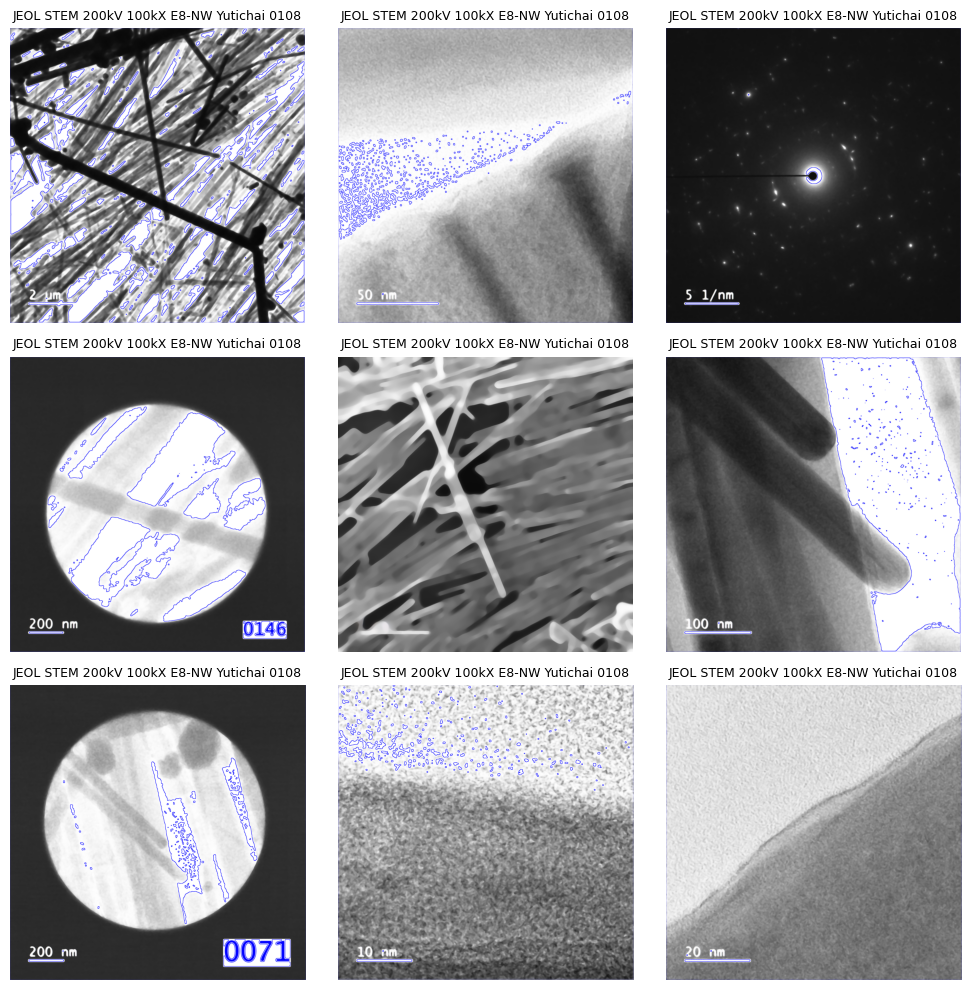

In [172]:
display_images(processed_images)

In [167]:
for processed_image, file_name in zip(processed_images, file_names):
    cv2.imwrite(OUTPUT_DIR_PATH + file_name + '.' + OUTPUT_FILE_EXTENSION, processed_image)   # Save the processed image
    print("Successfully saved " + file_name + '.' + OUTPUT_DIR_PATH)

Successfully saved OneView 200kV 5000X E8-NW Yutichai 0138../outputs/border_generation/
Successfully saved OneView 200kV 250kX E8-NW Yutichai 0024../outputs/border_generation/
Successfully saved OneView 200kV 600X E8-NW Yutichai 0150../outputs/border_generation/
Successfully saved OneView 200kV 25kX E8-NW Yutichai 0147../outputs/border_generation/
Successfully saved JEOL STEM 200kV 25kX E8-NW Yutichai 0114../outputs/border_generation/
Successfully saved OneView 200kV 100kX E8-NW Yutichai 0067../outputs/border_generation/
Successfully saved OneView 200kV 25kX E8-NW Yutichai 0072../outputs/border_generation/
Successfully saved OneView 200kV 800kX E8-NW Yutichai 0022../outputs/border_generation/
Successfully saved OneView 200kV 500kX E8-NW Yutichai 0037../outputs/border_generation/
Successfully saved JEOL STEM 200kV 100kX E8-NW Yutichai 0117../outputs/border_generation/
Successfully saved OneView 200kV 250kX E8-NW Yutichai 0125../outputs/border_generation/
Successfully saved OneView 200kV

# Test section

The code snippets below are solely used for testing purposes, and it can be ignored.

In [168]:
# Border Generation Function (Debugging version)
def generate_border_debug(image, border_size=5, n_erosions=1):
    # Ensure the input image is color (BGR)
    if len(image.shape) == 2:   # Convert greyscale to BGR
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 4:   # Convert RGBA to BGR
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGR)

    greyscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   # Convert the image to grayscale for erosion/dilation operations
    
    # Image erosion
    erosion_kernel = np.ones((3, 3), np.uint8)
    eroded_image_greyscale = cv2.erode(greyscale_image, erosion_kernel, iterations=n_erosions)

    # Image dilation
    kernel_size = 2 * border_size + 1   
    dilation_kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_image_grayscale = cv2.dilate(eroded_image_greyscale, dilation_kernel, iterations=1)
    
    plt.imshow(dilated_image_grayscale, cmap="gray")
    plt.show()

    # Create a mask for the border   
    border_color = (0, 0, 255) # Define the border color (BGR) 
    border_mask = ((dilated_image_grayscale == 255) & (eroded_image_greyscale < 255))    # The border region are pixels where dilated_image_gray is 255 but eroded_image_greyscale is not 255 (or 0)
    image_with_border = image.copy()    # Create a copy of the original color image to draw the border on 
    image_with_border[border_mask] = border_color  # Apply the border mask
    image_with_border_rgb = cv2.cvtColor(image_with_border, cv2.COLOR_BGR2RGB)  # Convert BRG to RGB

    plt.imshow(image_with_border_rgb)
    plt.show()

    return image_with_border

In [169]:
# Temporary put the function declaration here becuz I'm too lazy to scroll up
# Sowwy :3

# Image Properties Modification Function

# Note: The order of processing layers in this function matters

def modify_image(image, alpha=1.5, beta=2.0, guassian_kernel_size=5, diameter=9, sigmaColor=75, sigmaSpace=75, median_blur_kernel_size=9):
    processed_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    processed_image = cv2.GaussianBlur(processed_image, (guassian_kernel_size, guassian_kernel_size), 0)
    processed_image = cv2.bilateralFilter(processed_image, diameter, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)
    processed_image = cv2.medianBlur(processed_image, median_blur_kernel_size)
    processed_image = cv2.bilateralFilter(processed_image, diameter, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)
    processed_image = cv2.medianBlur(processed_image, median_blur_kernel_size)
    processed_image = cv2.medianBlur(processed_image, median_blur_kernel_size)

    return processed_image

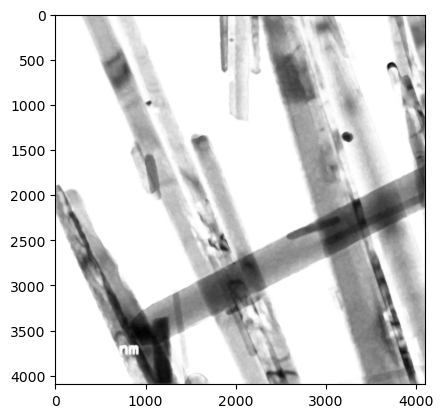

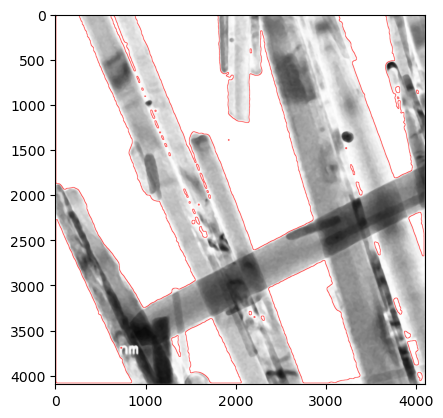

True

In [170]:
image = cv2.imread(IMAGES_DIR_PATH + "OneView 200kV 25kX E8-NW Yutichai 0003.tif", cv2.IMREAD_GRAYSCALE)
modified_image = modify_image(image, alpha=2.05, beta=2.5, guassian_kernel_size=11, diameter=12, sigmaColor=75, sigmaSpace=25, median_blur_kernel_size=17)
processed_image = generate_border_debug(modified_image)


cv2.imwrite(OUTPUT_DIR_PATH + "sample_output" + '.' + OUTPUT_FILE_EXTENSION, processed_image)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

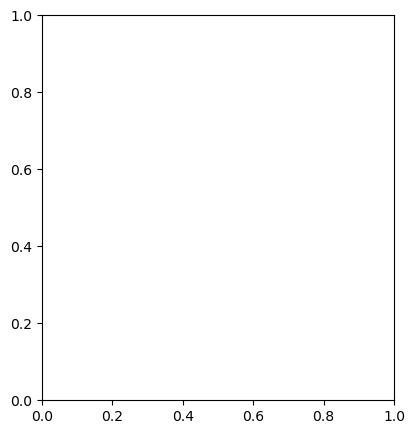

In [171]:
# Using Canny edge detection
edges = cv2.Canny(modified_image, threshold1=50, threshold2=150)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, ::-1])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap="gray")
plt.title("Detected Edges (Canny)")
plt.axis("off")
plt.show()